# Neural Network from Scratch Using PyTorch and Custom Dataset

In this activity, you will be introduced to PyTorch basics by implementing a simple neural network using a custom dataset (student pass/fail presented in previous session)

First we install PyTorch along with some other dependencies.

In [88]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

### Optional: If CUDA available: False
### 1. Go to the Runtime menu.
### 2. Select Change runtime type.
### 3. Set Hardware accelerator to available GPU and save.

PyTorch version: 2.9.0+cu128
CUDA available: True


and also our function to generate our custom dataset

In [89]:
def generate_pass_fail_dataset(n_samples=100, random_state=42):
    # Ensure n_samples is even for equal split
    n_samples = n_samples if n_samples % 2 == 0 else n_samples + 1
    n_per_class = n_samples // 2

    # Generate FAIL samples (low study hours, low attendance)
    # Students who DON'T meet: study_hours > 5 AND attendance > 70%
    fail_study_hours = np.random.normal(loc=3, scale=1.5, size=n_per_class) #most study around 3 hours, values range from 0-6 hours
    fail_study_hours = np.clip(fail_study_hours, 0, 6)  # Keep mostly below 5

    fail_attendance = np.random.normal(loc=50, scale=15, size=n_per_class)
    fail_attendance = np.clip(fail_attendance, 0, 75)  # Keep mostly below 70%
    fail_labels = np.zeros(n_per_class, dtype=int)

    # Generate PASS samples (high study hours, high attendance)
    # Students who meet: study_hours > 5 AND attendance > 70%
    pass_study_hours = np.random.normal(loc=7.5, scale=1.2, size=n_per_class)
    pass_study_hours = np.clip(pass_study_hours, 5, 10)  # Keep mostly above 5

    pass_attendance = np.random.normal(loc=85, scale=10, size=n_per_class)
    pass_attendance = np.clip(pass_attendance, 70, 100)  # Keep mostly above 70%

    pass_labels = np.ones(n_per_class, dtype=int)

    # Combine both classes
    study_hours = np.concatenate([fail_study_hours, pass_study_hours])
    attendance_rate = np.concatenate([fail_attendance, pass_attendance])
    y = np.concatenate([fail_labels, pass_labels])

    # Shuffle the data
    shuffle_idx = np.random.permutation(n_samples)
    study_hours = study_hours[shuffle_idx]
    attendance_rate = attendance_rate[shuffle_idx]
    y = y[shuffle_idx]

    # Combine features into a matrix
    X = np.column_stack((study_hours, attendance_rate))
    df = pd.DataFrame({'study_hours': study_hours, 'attendance_rate': attendance_rate, 'label': y})

    return X, y, df

## What is PyTorch?

PyTorch is a machine learning library, like TensorFlow. At its core, PyTorch provides an interface for creating and manipulating [tensors](https://pytorch.org/docs/stable/tensors.html), which are data structures that you can think of as multi-dimensional arrays.

Tensors are represented as n-dimensional arrays of base datatypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. PyTorch provides the ability to perform computation on these tensors, define neural networks, and train them efficiently.

The [```shape```](https://pytorch.org/docs/stable/generated/torch.Tensor.shape.html#torch.Tensor.shape) of a PyTorch tensor defines its number of dimensions and the size of each dimension. The `ndim` or [```dim```](https://pytorch.org/docs/stable/generated/torch.Tensor.dim.html#torch.Tensor.dim) of a PyTorch tensor provides the number of dimensions (n-dimensions) -- this is equivalent to the tensor's rank (as is used in TensorFlow), and you can also think of this as the tensor's order or degree.

Let’s start by creating some tensors and inspecting their properties:

In [90]:
integer = torch.tensor(1234)
decimal = torch.tensor(3.14159265359)

print(f"`integer` is a {integer.ndim}-d Tensor: {integer}")
print(f"`decimal` is a {decimal.ndim}-d Tensor: {decimal}")

`integer` is a 0-d Tensor: 1234
`decimal` is a 0-d Tensor: 3.1415927410125732


Vectors and lists can be used to create 1-d tensors:

In [91]:
fibonacci = torch.tensor([1, 1, 2, 3, 5, 8])
count_to_100 = torch.tensor(range(100))

print(f"`fibonacci` is a {fibonacci.ndim}-d Tensor with shape: {fibonacci.shape}")
print(f"`count_to_100` is a {count_to_100.ndim}-d Tensor with shape: {count_to_100.shape}")

`fibonacci` is a 1-d Tensor with shape: torch.Size([6])
`count_to_100` is a 1-d Tensor with shape: torch.Size([100])


Next, let’s create 2-d (i.e., matrices) and higher-rank tensors.

In image processing and computer vision, we will use 4-d Tensors with dimensions corresponding to batch size, number of color channels, image height, and image width.

In [92]:
### Defining higher-order Tensors ###

'''A 2-d Tensor'''
matrix = torch.tensor([[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0]])

'''A 4-d Tensor.'''
#   You can think of this as 10 images where each image is RGB 256 x 256.
images = torch.zeros(10, 3, 256, 256)

assert images.shape == (10, 3, 256, 256), "images is incorrect shape"
print(f"images is a {images.ndim}-d Tensor with shape: {images.shape}")

images is a 4-d Tensor with shape: torch.Size([10, 3, 256, 256])


As you have seen, the `shape` of a tensor provides the number of elements in each tensor dimension. The `shape` is quite useful, and we'll use it often. You can also use slicing to access subtensors within a higher-rank tensor:

In [93]:
row_vector = matrix[1]
column_vector = matrix[:, 1]
scalar = matrix[0, 1]

print(f"`row_vector`: {row_vector}")
print(f"`column_vector`: {column_vector}")
print(f"`scalar`: {scalar}")

`row_vector`: tensor([5., 6., 7., 8.])
`column_vector`: tensor([2., 6.])
`scalar`: 2.0


## Computations on Tensors

A convenient way to think about and visualize computations in a machine learning framework like PyTorch is in terms of graphs. We can define this graph in terms of tensors, which hold data, and the mathematical operations that act on these tensors in some order. Let's look at a simple example, and define this computation using PyTorch:

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/add-graph.png)

In [94]:
# Create the nodes in the graph and initialize values
a = torch.tensor(15)
b = torch.tensor(61)

# Add them!
c1 = torch.add(a, b)
c2 = a + b  # PyTorch overrides the "+" operation so that it is able to act on Tensors
print(f"c1: {c1}")
print(f"c2: {c2}")

c1: 76
c2: 76


Notice how we've created a computation graph consisting of PyTorch operations, and how the output is a tensor with value 76.

Now let's consider a slightly more complicated example:

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/computation-graph.png)

Here, we take two inputs, `a, b`, and compute an output `e`. Each node in the graph represents an operation that takes some input, does some computation, and passes its output to another node.

Let's define a simple function in PyTorch to construct this computation function:

In [95]:
### Defining Tensor computations ###

# A simple computation function
def func(a, b):
    c = torch.add(a, b)
    d = torch.subtract(b, 1)
    e = torch.multiply(c, d)
    return e


Now, we can call this function to execute the computation graph given some inputs `a,b`:

In [96]:
# Consider example values for a,b
a, b = 1.5, 2.5
# Execute the computation
e_out = func(a, b)
print(f"e_out: {e_out}")

e_out: 6.0


Notice how our output is a tensor with value defined by the output of the computation, and that the output has no shape as it is a single scalar value.

## Neural networks in PyTorch

We can also define neural networks in PyTorch. PyTorch uses [``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which serves as a base class for all neural network modules in PyTorch and thus provides a framework for building and training neural networks.

Let's consider the example of a simple perceptron defined by just one dense (aka fully-connected or linear) layer: $ y = \sigma(Wx + b) $, where $W$ represents a matrix of weights, $b$ is a bias, $x$ is the input, $\sigma$ is the sigmoid activation function, and $y$ is the output.

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/computation-graph-2.png)

We will use `torch.nn.Module` to define layers -- the building blocks of neural networks. Layers implement common neural networks operations. In PyTorch, when we implement a layer, we subclass `nn.Module` and define the parameters of the layer as attributes of our new class. We also define and override a function [``forward``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.forward), which will define the forward pass computation that is performed at every step. All classes subclassing `nn.Module` should override the `forward` function.

Let's write a dense layer class to implement a perceptron defined above.

In [97]:
### Defining a dense layer ###

# num_inputs: number of input nodes
# num_outputs: number of output nodes
# x: input to the layer
  # For reproducibility
class OurDenseLayer(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(OurDenseLayer, self).__init__()
        # Define and initialize parameters: a weight matrix W and bias b
        self.W = torch.nn.Parameter(torch.randn(num_inputs, num_outputs))
        self.bias = torch.nn.Parameter(torch.randn(num_outputs))

    def forward(self, x):
        z = torch.matmul(x, self.W) + self.bias
        y = torch.sigmoid(z)
        return y


Now, let's test the output of our layer.

In [98]:
# Define a layer and test the output!
num_inputs = 2
num_outputs = 3

layer = OurDenseLayer(num_inputs, num_outputs)
x_input = torch.tensor([[1, 2.]])
y = layer(x_input)

# print(f"{torch.randn(num_inputs, num_outputs)}")
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.9528, 0.0598, 0.5802]], grad_fn=<SigmoidBackward0>)


Conveniently, PyTorch has defined a number of ```nn.Modules``` (or Layers) that are commonly used in neural networks, for example a [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) or [`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) module.

Now, instead of using a single ```Module``` to define our simple neural network, we'll use the  [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module from PyTorch and a single [`nn.Linear` ](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer to define our network. With the `Sequential` API, you can readily create neural networks by stacking together layers like building blocks.

In [99]:
### Defining a neural network using the PyTorch Sequential API ###

# define the number of inputs and outputs
n_input_nodes = 2
n_output_nodes = 3

# Define the model
model = nn.Sequential(
    # linear layer with input size 2 and output size 3
    nn.Linear(n_input_nodes, n_output_nodes),
    # Sigmoid activation function
    nn.Sigmoid()
)


We've defined our model using the Sequential API. Now, we can test it out using an example input:

In [100]:
# Test the model with example input
x_input = torch.tensor([[1, 2.]])
model_output = model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {model_output.shape}")
print(f"output result: {model_output}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.3337, 0.5562, 0.2417]], grad_fn=<SigmoidBackward0>)


With PyTorch, we can create more flexible models by subclassing [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The `nn.Module` class allows us to group layers together flexibly to define new architectures.

As we saw earlier with `OurDenseLayer`, we can subclass `nn.Module` to create a class for our model, and then define the forward pass through the network using the `forward` function. Subclassing affords the flexibility to define custom layers, custom training loops, custom activation functions, and custom models. Let's define the same neural network model as above (i.e., Linear layer with an activation function after it), now using subclassing and using PyTorch's built in linear layer from `nn.Linear`.

In [101]:
### Defining a model using subclassing ###

class LinearWithSigmoidActivation(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearWithSigmoidActivation, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        linear_output = self.linear(inputs)
        output = self.activation(linear_output)
        return output


Let's test out our new model, using an example input, setting `n_input_nodes=2` and `n_output_nodes=3` as before.

In [102]:
n_input_nodes = 2
n_output_nodes = 3
model = LinearWithSigmoidActivation(n_input_nodes, n_output_nodes)
x_input = torch.tensor([[1, 2.]])
y = model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.7341, 0.6460, 0.5572]], grad_fn=<SigmoidBackward0>)


## Automatic Differentiation in PyTorch

In PyTorch, [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html) is used for [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which is critical for training deep learning models with [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

We will use the PyTorch [`.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) method to trace operations for computing gradients. On a tensor, the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) attribute controls whether autograd should record operations on that tensor. When a forward pass is made through the network, PyTorch builds a computational graph dynamically; then, to compute the gradient, the `backward()` method is called to perform backpropagation.

Let's compute the gradient of $ y = x^2 $:

In [103]:
### Gradient computation ###

# y = x^2
# Example: x = 3.0
x = torch.tensor(3.0, requires_grad=True)
y = x ** 2
y.backward()  # Compute the gradient

dy_dx = x.grad
print("dy_dx of y=x^2 at x=3.0 is: ", dy_dx)
assert dy_dx == 6.0


dy_dx of y=x^2 at x=3.0 is:  tensor(6.)


In training neural networks, we use differentiation and stochastic gradient descent (SGD) to optimize a loss function. Now that we have a sense of how PyTorch's autograd can be used to compute and access derivatives, we will look at an example where we use automatic differentiation and SGD to find the minimum of $ L=(x-x_f)^2 $. Here $x_f$ is a variable for a desired value we are trying to optimize for; $L$ represents a loss that we are trying to minimize.

Initializing x=0.2673508822917938


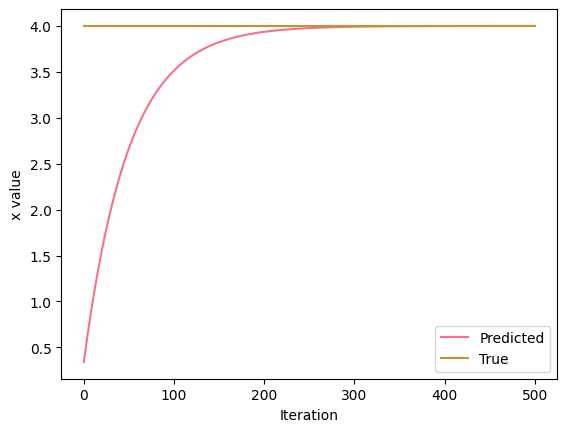

In [104]:
### Function minimization with autograd and gradient descent ###

# Initialize a random value for our intial x
x = torch.randn(1)
print(f"Initializing x={x.item()}")

learning_rate = 1e-2  # Learning rate
history = []
x_f = 4  # Target value


# We will run gradient descent for a number of iterations. At each iteration, we compute the loss,
#   compute the derivative of the loss with respect to x, and perform the update.
for i in range(500):
    x = torch.tensor([x], requires_grad=True)

    # Compute the loss as the square of the difference between x and x_f
    loss = (x - x_f) ** 2

    # Backpropagate through the loss to compute gradients
    loss.backward()

    # Update x with gradient descent
    x = x.item() - learning_rate * x.grad

    history.append(x.item())

# Plot the evolution of x as we optimize toward x_f!
plt.plot(history)
plt.plot([0, 500], [x_f, x_f])
plt.legend(('Predicted', 'True'))
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.show()


# **Activity: Build a student pass/fail classifier**

Build and train a neural network to predict whether a student will pass or fail based on their study hours and attendance rate.

TASKS:
1. Load, explore, and visualize the dataset
2. Prepare the data (convert to tensors, split train/test)
3. Design a neural network architecture
4. Define loss function and optimizer
5. Train the model
6. Evaluate performance
7. Visualize results

### TASK 1: Load, explore, and visualize the dataset

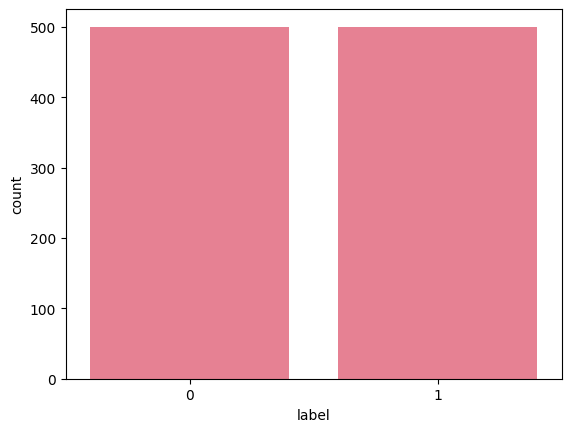

In [105]:
X, y, grades_df = generate_pass_fail_dataset(n_samples=1000, random_state=42)
sns.countplot(x='label',data=grades_df)
plt.show()

The dataset has a total of 1000 students, 500 which passed on exams (has label `1`) and the other 500 whom have failed (has label `0`)

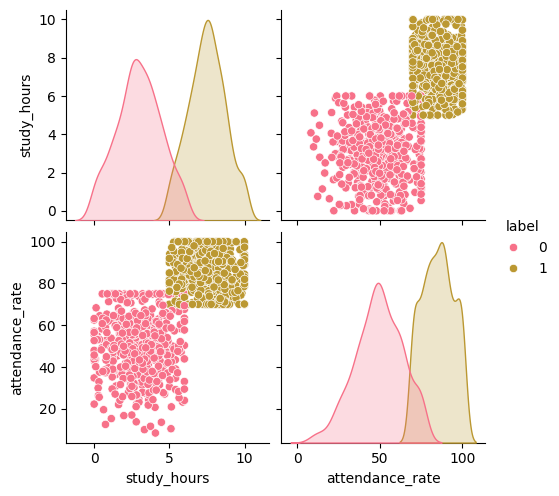

In [106]:
#determine the correlation between variables
sns.pairplot(data=grades_df,hue='label')
plt.show()

In [107]:
#Pass grades sorted by study hours
pass_sorted_sh = grades_df[grades_df['label'] == 1].sort_values('study_hours')
#Failed grades sorted by study hours
failed_sorted_sh = grades_df[grades_df['label'] == 0].sort_values('study_hours')
print(failed_sorted_sh)
print(pass_sorted_sh)

     study_hours  attendance_rate  label
653          0.0        44.971817      0
119          0.0        34.716747      0
621          0.0        55.387542      0
644          0.0        57.097048      0
146          0.0        47.916236      0
..           ...              ...    ...
854          6.0        29.363304      0
960          6.0        69.342338      0
139          6.0        43.849132      0
202          6.0        67.557499      0
944          6.0        61.806004      0

[500 rows x 3 columns]
     study_hours  attendance_rate  label
965          5.0        76.280625      1
84           5.0        70.000000      1
915          5.0        80.377265      1
904          5.0        79.555754      1
162          5.0        81.578406      1
..           ...              ...    ...
863         10.0        79.835679      1
70          10.0        93.871266      1
873         10.0        81.962096      1
137         10.0        88.953836      1
207         10.0        91.960301

In [108]:
#Pass grades sorted by attendance_rate
pass_sorted_ar = grades_df[grades_df['label'] == 1].sort_values('attendance_rate')
#Failed grades sorted by attendance_rate
failed_sorted_ar = grades_df[grades_df['label'] == 0].sort_values('attendance_rate')
print(failed_sorted_ar)
print(pass_sorted_ar)

     study_hours  attendance_rate  label
243     4.073148         8.310588      0
88      3.341681         9.915964      0
553     5.108914        10.374479      0
819     3.747760        11.539142      0
953     0.752013        12.425380      0
..           ...              ...    ...
898     1.260016        75.000000      0
221     5.079901        75.000000      0
255     3.215321        75.000000      0
800     4.365470        75.000000      0
105     4.859487        75.000000      0

[500 rows x 3 columns]
     study_hours  attendance_rate  label
981     6.536208             70.0      1
36      7.420002             70.0      1
921     7.481360             70.0      1
927     7.617933             70.0      1
84      5.000000             70.0      1
..           ...              ...    ...
895     6.025881            100.0      1
917     6.936777            100.0      1
61      7.101165            100.0      1
991     7.866614            100.0      1
994     7.522916            100.0

`study_hours`: Its peak are for those who passed is 10 hours while those that didn't is 6 hours as we intitalized in the function `generate_pass_fail_dataset`
`attendance_rate`: Its peak are for those who passed is 100% attendance_rate while those that didn't is have 75% attendance_rate as we intitalized in the function `generate_pass_fail_dataset`

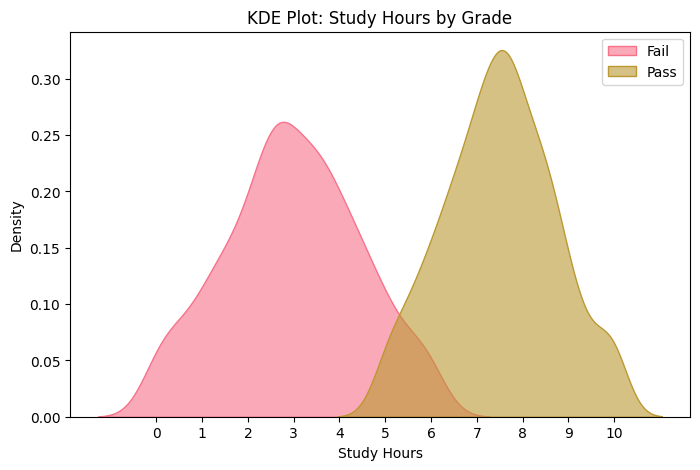

In [109]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=grades_df[grades_df['label'] == 0], x='study_hours',  fill=True, label='Fail', alpha=0.6)
sns.kdeplot(data=grades_df[grades_df['label'] == 1], x='study_hours', fill=True, label='Pass', alpha=0.6)
plt.xlabel('Study Hours')
plt.ylabel('Density')
plt.title('KDE Plot: Study Hours by Grade')
plt.xticks([0, 1, 2, 3, 4, 5, 6 ,7, 8, 9, 10])
plt.legend()
plt.show()

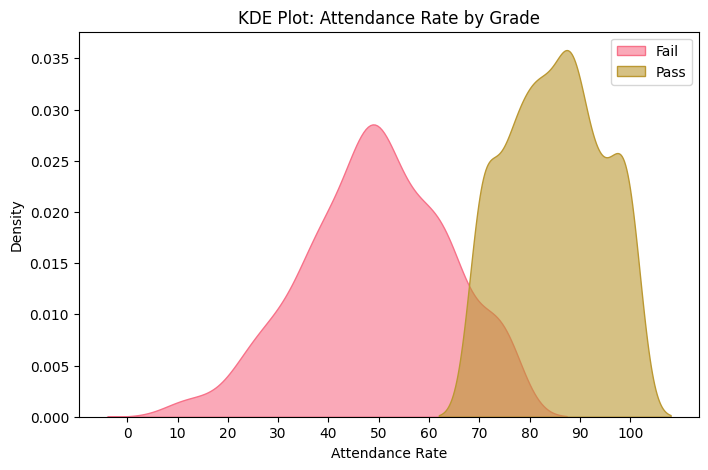

In [110]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=grades_df[grades_df['label'] == 0], x='attendance_rate',  fill=True, label='Fail', alpha=0.6)
sns.kdeplot(data=grades_df[grades_df['label'] == 1], x='attendance_rate', fill=True, label='Pass', alpha=0.6)
plt.xlabel('Attendance Rate')
plt.ylabel('Density')
plt.title('KDE Plot: Attendance Rate by Grade')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.legend()
plt.show()

`study_hours` KDE Plot: For those that have `failed`, their study hours are mostly around 3 hours while for those that `passed` have theirs mostly around 8 hours. They are those in the range of 4-7 in study hours where those that `passed` and `failed` intersect.  
`attendance_rate` KDE Plot: For those that have `failed`, their attendance rate are mostly around 45% while for those that `passed` have theirs mostly around 85-90%. They are those in the range of 60-90% in attendance rate where those that `passed` and `failed` intersect.

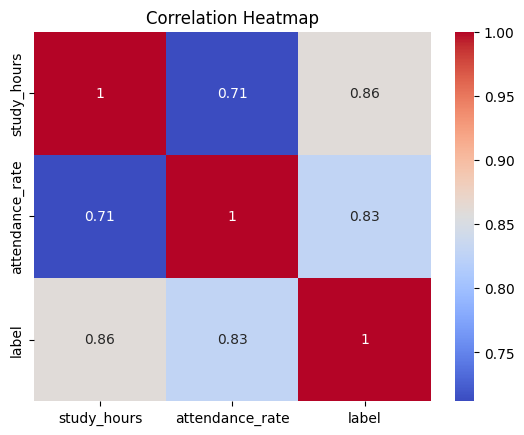

In [111]:
# If your dataset is a DataFrame called grades_df
corr_matrix = grades_df.corr()  # Compute correlation matrix

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

`study_hours` and `attendance_rate` have a correlation coefficient of 0.69, this generally means that they have a positive linear relationship (eg. Increase in attendance likely indicates increase in  study hours and vice versa)

### TASK 2: Prepare the data

In [112]:
# -- Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# -- Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print("Shapes — X_train:", X_train.shape, "X_test:", X_test.shape, "X_val:", X_val.shape)


Shapes — X_train: torch.Size([600, 2]) X_test: torch.Size([200, 2]) X_val: torch.Size([200, 2])


In [113]:
# TASK 3: Implement neural network architecture
#  -- Architecture:
#  -- Input layer: 2 features (study_hours, attendance_rate)
#  -- Hidden layer: 8 neurons with ReLU activation
#  -- Hidden layer: 4 neurons with ReLU activation
#  -- Output layer: 1 neuron with Sigmoid activation (binary classification)
### Defining a neural network using the PyTorch Sequential API ###
n_input_nodes = 2
n_h1_nodes = 8
n_h2_nodes = 4
n_output_nodes = 1

# Define the model
seq_nn = nn.Sequential(
    nn.Linear(n_input_nodes, n_h1_nodes),
    nn.ReLU(),
    nn.Linear(n_h1_nodes, n_h2_nodes),
    nn.ReLU(), 
    nn.Linear(n_h2_nodes, n_output_nodes),
    nn.Sigmoid()
)
print(seq_nn)

# class ClassNN(nn.Module):
#     def __init__(self, num_inputs, hidden_layer_sizes, num_outputs):
#         super(ClassNN, self).__init__()
#         self.layers = nn.ModuleList()

#         self.layers.append(nn.Linear(num_inputs, hidden_layer_sizes[0], bias=True))
#         self.layers.append(nn.ReLU())

#         # Hidden layers
#         for i in range(len(hidden_layer_sizes) - 1):
#             self.layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1], bias=True))
#             self.layers.append(nn.ReLU()) 

#         # Last hidden layer to output layer
#         self.layers.append(nn.Linear(hidden_layer_sizes[-1], num_outputs, bias=True))
#         self.layers.append(nn.Sigmoid())

#     def forward(self, inputs):
#         for layer in self.layers:
#             inputs = layer(inputs)
#         return inputs

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)


In [114]:

torch.manual_seed(42)
# Sequential Model Implementation
seq_model = seq_nn(X_train.float())
print(f"input shape: {X_train.shape}")
print(f"output shape: {seq_model.shape}")
print(f"output result: {seq_model}")

# Class Model Implementation
# n_input_nodes = 2
# n_hiddens_nodes = [8,4]
# n_output_nodes = 1
# class_model = ClassNN(n_input_nodes, n_hiddens_nodes, n_output_nodes)
# # x_input = torch.tensor([[1, 2.]])
# class_res = class_model(X_train.float())
# print(f"input shape: {X_train.shape}")
# print(f"output shape: {class_res.shape}")
# print(f"output result: {class_res}")



input shape: torch.Size([600, 2])
output shape: torch.Size([600, 1])
output result: tensor([[5.2726e-05],
        [2.6307e-05],
        [5.1568e-02],
        [3.3079e-03],
        [3.2471e-04],
        [3.2251e-05],
        [6.9719e-03],
        [9.4971e-03],
        [1.3779e-04],
        [8.8759e-03],
        [4.5390e-05],
        [2.0186e-05],
        [5.5237e-02],
        [2.7721e-04],
        [7.4284e-05],
        [3.4962e-05],
        [1.9458e-05],
        [3.4468e-04],
        [3.2106e-04],
        [4.4270e-03],
        [5.6398e-03],
        [2.0988e-05],
        [5.0283e-05],
        [1.7241e-05],
        [7.8108e-04],
        [4.3696e-05],
        [2.7681e-03],
        [1.1713e-02],
        [1.0180e-05],
        [2.9814e-04],
        [7.9806e-05],
        [2.1527e-04],
        [5.2661e-03],
        [7.4397e-04],
        [1.0193e-05],
        [1.8360e-04],
        [4.8313e-03],
        [4.5762e-03],
        [4.7351e-02],
        [3.7852e-03],
        [3.9288e-05],
        [4.266

In [115]:
# TASK 4: Implement loss function and optimizer
# -- Loss function: Binary Cross-Entropy
# -- Optimizer: Adam


learning_rate = 1e-2  # Learning rate
history = []
val_history = []
actual_val = y_train.float().detach().clone().requires_grad_(True) 
actual_val_reshaped = actual_val.unsqueeze(1)
iterations = 500          

optimizer = torch.optim.Adam(seq_nn.parameters(), lr=learning_rate)
loss_func = nn.BCELoss()




In [116]:
# TASK 5: Train the model
seq_nn.train()
print("Starting Training...")
for epoch in range(iterations):
    # A. ZERO THE GRADIENTS
    optimizer.zero_grad()

    # B. FORWARD PASS
    outputs = seq_nn(X_train)
    loss = loss_func(outputs, actual_val_reshaped)

    # C. BACKWARD PROPAGATION
    loss.backward()
    
    # D. PARAMETER UPDATE
    optimizer.step()
    
    # E. MONITORING & ACCURACY CALCULATION
    predicted_classes = torch.round(outputs)
    correct_predictions = predicted_classes.eq(actual_val_reshaped).sum().item()
    total_samples = len(X_train)
    accuracy = (correct_predictions / total_samples) * 100
    
    history.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        log_line = f'Epoch [{epoch + 1}/{iterations}], Loss: {loss.item():.4f}, Train Accuracy: {accuracy:.2f}%'
    # F. VALIDATION CHECK
    if (epoch + 1) % 50 == 0:
        seq_nn.eval() # Set to evaluation mode
        with torch.no_grad():
            val_outputs = seq_nn(X_val)
            val_loss = loss_func(val_outputs, y_val.unsqueeze(1)).item()
            
            val_predictions = torch.round(val_outputs)
            val_correct = val_predictions.eq(y_val.unsqueeze(1)).sum().item()
            val_accuracy = (val_correct / len(X_val)) * 100
        
        val_history.append(val_loss)

        seq_nn.train() # Switch back to training mode
        
        log_line += f' | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%'
    
    if (epoch + 1) % 50 == 0:
        print(log_line)

print('Finished Training!')

Starting Training...
Epoch [50/500], Loss: 0.6458, Train Accuracy: 61.33% | Val Loss: 0.6417, Val Acc: 63.00%
Epoch [100/500], Loss: 0.5810, Train Accuracy: 66.00% | Val Loss: 0.5781, Val Acc: 68.50%
Epoch [150/500], Loss: 0.4848, Train Accuracy: 82.17% | Val Loss: 0.4814, Val Acc: 83.00%
Epoch [200/500], Loss: 0.3388, Train Accuracy: 91.17% | Val Loss: 0.3382, Val Acc: 90.00%
Epoch [250/500], Loss: 0.1045, Train Accuracy: 98.83% | Val Loss: 0.1113, Val Acc: 98.00%
Epoch [300/500], Loss: 0.0536, Train Accuracy: 98.83% | Val Loss: 0.0669, Val Acc: 98.50%
Epoch [350/500], Loss: 0.0411, Train Accuracy: 99.00% | Val Loss: 0.0583, Val Acc: 98.00%
Epoch [400/500], Loss: 0.0344, Train Accuracy: 99.00% | Val Loss: 0.0540, Val Acc: 98.00%
Epoch [450/500], Loss: 0.0303, Train Accuracy: 98.67% | Val Loss: 0.0519, Val Acc: 98.00%
Epoch [500/500], Loss: 0.0274, Train Accuracy: 98.67% | Val Loss: 0.0509, Val Acc: 98.00%
Finished Training!


In [117]:
# TASK 6: Evaluate performance
# -- Predictions on test set
# -- Calculate accuracy
seq_nn.eval()
with torch.no_grad(): # Disable gradient calculations
    # Predictions on test set
    test_outputs = seq_nn(X_test)
    
    # Calculate test accuracy
    test_predictions = torch.round(test_outputs)
    # Prepare target labels for testing
    test_target_labels = y_test.float().unsqueeze(1) 
    
    # Compare predictions to true labels
    test_correct = test_predictions.eq(test_target_labels).sum().item()
    test_total = len(X_test)
    test_accuracy = (test_correct / test_total) * 100
    
    print(f'\n--- Evaluation on Test Set (N={test_total}) ---')
    print(f'Test Accuracy: {test_accuracy:.2f}%')


--- Evaluation on Test Set (N=200) ---
Test Accuracy: 99.00%


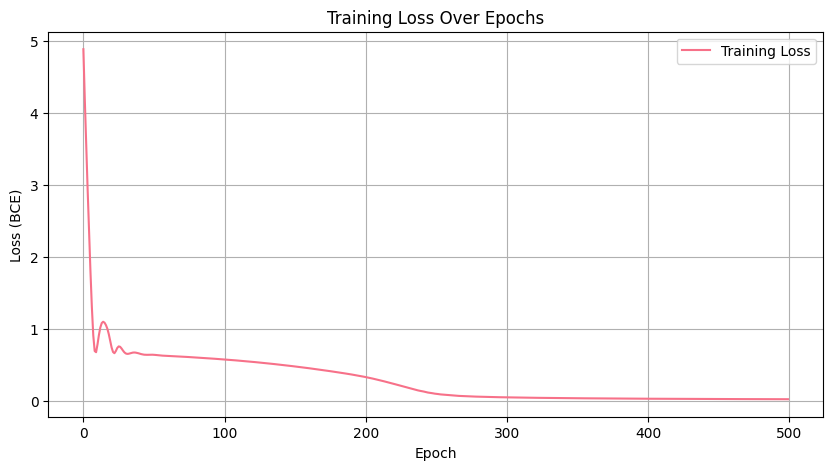

In [118]:
# TASK 7: Visualize results
# -- Plot training history
# -- Loss curves
# -- Decision boundary
plt.figure(figsize=(10, 5))
plt.plot(history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)
plt.show()



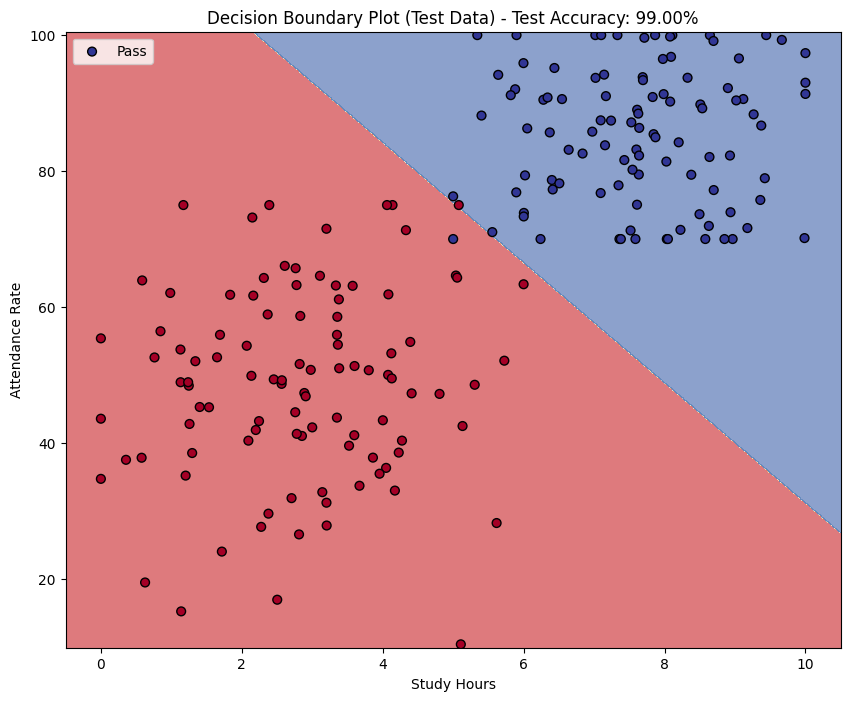

In [119]:
# B. Plot Decision Boundary (Since INPUT_SIZE=2)
# Define the range for the plot
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5

# Create a grid of points (100x100 points)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))

# Convert grid points to a tensor for prediction
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Predict class for each point on the grid
with torch.no_grad():
    Z_outputs = seq_nn(grid_tensor)
    # Convert probabilities to class (0 or 1) and reshape for plotting
    Z = torch.round(Z_outputs).numpy().reshape(xx.shape)

# Plot the decision boundary and the test data
plt.figure(figsize=(10, 8))
# Use contourf to fill the background according to the predicted class Z
plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.RdYlBu)
# Scatter plot the actual test data points, colored by their true label (y_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title(f'Decision Boundary Plot (Test Data) - Test Accuracy: {test_accuracy:.2f}%')
plt.xlabel('Study Hours')
plt.ylabel('Attendance Rate')
plt.legend(['Pass'], loc='upper left')
plt.show()

**REFLECTION QUESTIONS:**

1. Why do we use sigmoid activation in the output layer for binary classification?

    > We use it as it gives a value between 0 and 1, where in we can treat the value as probabilities. If the value is >0.5 then it is likelier to be 0 and vice versa. We then utilize a certain threshold (usually 0.5) wherein every probability that goes below or above it is treated as either a positive or negative case, ensuring that we only get 2 values which is what we want in Binary Classification.



2. What would happen if we increased/decreased the number of hidden neurons?

    >- Pros of Increasing number of hidden neurons: Increased model accuracy and capability up to a certain point, reduces likelihood of underfitting  
    >- Its Cons: Diminishing returns in model accuracy and capability at a certain point, overfitting, and increase in computational cost  
    >- Pros of Decreasing number of hidden neurons: Easier to interpret/understand how they work, more computationaly efficient, reduced overfitting  
    >- Its Cons: Reduced Accuracy, Underfitting, Learning Instability
    


3. How does the learning rate affect the training process?
    
    > It affects how your model is taking steps to reach the best solution for your problem. It helps by determining how much change do you want to happen to your weights and bias. The higher it is, the greater the change and potentially barring you from converging to a minimum but if it is too small, it would cause little change to your weights which makes your model stuck on suboptimal solutions

4. What other metrics besides accuracy could we use to evaluate our model?
    >  Given that our task involves classification, we can use:  
    >- Confusion Matrix (to count the True and False Positives and Negatives)  
    >- Precision (ratio between our true postives and all positive predicitions)  
    >- Recall (ratio between the true positives and true positives + false negatives)  
    >- F1-Score (A balance of precision and recall)  
    >- ROC-AUC (how well the model distinguishes classes)  
    >- Logarithmic Loss (how close the predicted probabilities are to the actual class labels)

5. How could we prevent overfitting if we noticed the test loss increasing?
    > We can prevent it by making the model stop training first to diagnose the problem, augment data to help it generalize better, and prune the features for the model to train only on relevant ones

---

## **Submission Instructions**

- Upload your completed Notebook to your **GitHub repository**.  
- Ensure the filename follows this format:  
  **`CSC173_Activity02_Lastname_Firstname.ipynb`**
- Make sure all code cells have been executed and outputs are visible.   
- Submit the **GitHub repository link** containing your notebook in the MOLE Assignment page.  
- **Deadline:** *November 3, 2025, 11:59 PM*

---
